## Big Data : M508A
### Final Assessment : Mental Health Text Classification 

## 1.Introduction
Mental health is increasingly becoming a big issue especially in cooperate environment. Most companies recognise mental health as a real problem and even offer further assistance to their employees. As a data scientist in a software development company, am tasked to design a chatbot application that has been trained to classify a user's statement into 7 classes of mental status e.g. anxiety, stress and suicidal.

### 1.1 Problem Statement
40% of the mental health incidents could have been detected and prevented early.

### 1.2 Proposed Solution 
With more and more people opting for online therapy, a transformer model used for text classification task could help classify a text into the type of mental health one suffers from. This can be done through training a model from an already classified dataset with examples of text that match the mental health class. A transformer model with a pretrained Bert model could learn the patterns in a sequence of words. With its attention mechanism that uses (key, query and value) when assigning weights, a transformer model would be suitable to pick patterns from the input text that do match the classes with more accuracy as apposed to traditional models like word2vec.

### 1.3 Data Collection Process
For this project will use publicly available data from Kaggle 

(https://www.kaggle.com/code/marcosafonso/mental-health-sentiment-analysis/input?select=Combined+Data.csv.) 

In future the company would be required to do a voluntary lab experiment with a group of people from different areas of the country. They could offer free only therapy consultation and ask the volunteers to consent to their data being used to train an AI model.

## 2. System Design

1. Clean and Prepare raw text
First step is to Check for any duplicated texts and empty rows, drop these. Use distilbert-base-uncased tokenizer for tokenazation of the text. Set a maximum position embending to pad and trancate the sequence. This ensures that the data being fed in the model as input data is in the format the model can undertsand.



2. Model
Takes in the input tokens and creates meaningful embadings. Has 6 encoder layers, 12 attention head and suitable for sequence classification tasks. The model encodes the raw text, adds weights using attention mechanisim pass the embeded data to the decoder that translates this to outputs(labels).



3. Expected Output
That the model uses encoder decoder technique to find and create patterns in that text that will allow proper classification. Maps logits to lables using id2label/label2id. Deccode the token probabilities into text.

## 3. Dataset Exploration 
The dataset contains text from over 50,000 users, the statements are classified into 7 categories/labels of the mental health identified e.g. anxiety, depression etc. The dataset has a few empty rows and duplicated text that I will remove before splitting the input data. Input data will be split into training, validation and test set. There is an imbalance in the dataset, the label with the most rows is Normal with 16,000 rows and the label with the list is personality disorder with 1200 for this response I will engineer the label allocation and allocate 1000 rows for each label. This reduces the possibility of the model learning very well one label and not the rest.

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn

### 3.1 Initiate CUDA 
To utilize my PC NVIDIA GPU.

In [205]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 3.2 Load and sample the dataset

In [207]:
df = pd.read_csv("Mental Health.csv")
df.sample(5)

,Unnamed: 0,statement,status
9189,9189,Chronic Depression. I am at this nihilistic po...,Suicidal
31382,31382,bluedog123 is just the street. you have to giv...,Normal
3729,3729,look again it's 71 not 7l âœ‹ðŸ »,Normal
34626,34626,Terrified of a brain bleed... This sounds so r...,Anxiety
9589,9589,No idea where my life is going. Feeling depres...,Depression


### 3.3 Check shape of the data

In [209]:
df.shape

(53043, 3)

### 3.4 Check for empty rows

In [211]:
df.isna().sum()

Unnamed: 0      0
statement     362
status          0
dtype: int64

### 3.5 Checking data distribution

In [213]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

## 4. Data Cleaning and Feature Engineering
### 4.1 Drop columns and rows
Dropped the unnamed column to reduce data noise, there are no important information in this column. Dropped the empty column as they will introduce unnecessary noise. Dropped the duplicated data as it will reduces the opportunity of the model to learn from new data.

In [215]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [217]:
df.dropna(inplace=True)

In [219]:
df.duplicated().sum()

1588

In [221]:
df.drop_duplicates(inplace=True)

### 4.2 Equal label distribution

In [225]:
desired_count = 1000
df = pd.concat([group.sample(n=desired_count, random_state=42, replace=len(group) < desired_count)for _, group in df.groupby('status')])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print(df['status'].value_counts())

status
Suicidal                1000
Depression              1000
Anxiety                 1000
Personality disorder    1000
Normal                  1000
Stress                  1000
Bipolar                 1000
Name: count, dtype: int64


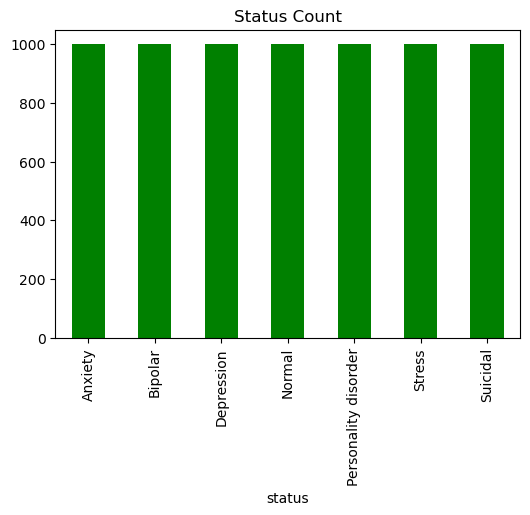

In [227]:
axis = df['status'].value_counts().sort_index().plot(kind='bar',title='Status Count',figsize=(6,4),color='green')

## 5. Splitting Dataset
The labels will be the 7 statuses from the status column and the text to be analysed as input features from the statement column. Allocating equal data to test and validation set. Using random state to split the rows randomly and in no order. The original csv file had the labels in order hence why this part is important to reduce any biases.

In [229]:
texts = df['statement']
labels = df['status']

In [231]:
label_mapping = {label: idx for idx, label in enumerate(labels.unique())}
labels = labels.map(label_mapping).values

In [233]:
print(labels[90])

4


In [235]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.25, random_state=42)
print(f"Train size: {len(train_texts)}")
print(f"Validation size: {len(val_texts)}")
print(f"Test size: {len(test_texts)}")

Train size: 4200
Validation size: 1400
Test size: 1400


### 6. Tokenizer Exploration
The auto tokenizer assigned distilberttokenizerfast, i used auto tokenizer from hugging face to enhance the tokenizer assignment so that its only the most compatible tokenizer that is assigned to the model. I used index 6999 as a sample input text to explore the tokenizer.

In [237]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
print(f"Tokenizer class: {tokenizer.__class__.__name__}")

Tokenizer class: DistilBertTokenizerFast


In [239]:
sample = df['statement'][6999]
print(sample)

Cold Sores How bad that is?


In [241]:
tokens_with_words = tokenizer.tokenize(sample)
print(tokens_with_words)

['cold', 'sore', '##s', 'how', 'bad', 'that', 'is', '?']


In [243]:
tokens = tokenizer.encode(sample)
print(tokens)

[101, 3147, 14699, 2015, 2129, 2919, 2008, 2003, 1029, 102]


In [245]:
print(f"Special tokens: {tokenizer.special_tokens_map}")

Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}


In [247]:
for token_id in tokens:
    print(f"Token ID: {token_id}, Token: {tokenizer.convert_ids_to_tokens([token_id])[0]}")

Token ID: 101, Token: [CLS]
Token ID: 3147, Token: cold
Token ID: 14699, Token: sore
Token ID: 2015, Token: ##s
Token ID: 2129, Token: how
Token ID: 2919, Token: bad
Token ID: 2008, Token: that
Token ID: 2003, Token: is
Token ID: 1029, Token: ?
Token ID: 102, Token: [SEP]


In [249]:
print(f"Number of tokens: {len(tokens)}")

Number of tokens: 10


In [251]:
inputs = torch.tensor(tokens).unsqueeze(0)
print(inputs)

tensor([[  101,  3147, 14699,  2015,  2129,  2919,  2008,  2003,  1029,   102]])


### 7. Model Exploration
The model used is DistilBertForSequenceClassification, with GELU(Gaussian Error Linear Unit) as the activation function. It has a vector representation of dim:768 and a feed forward network with a capacity of 3072 (hidden_dim). There 12 attention heads, 6 encoder layers and drop-out set at 0.1. Used the sample index to explore the features of the model, like how different words pay attention to each other in a sequence. The data frame shows the percentages, and the heat map shows the colour coding on how the tokens are paying attention to each other. For both the examples I have looked at the attention on layer 1.

In [254]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_mapping), output_attentions=True)
model.to(device)
print(f"Model class: {model.__class__.__name__}")
print(f"Model configuration: {model.config}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model class: DistilBertForSequenceClassification
Model configuration: DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_attentions": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.47.0",
  "vocab_size": 30522
}



In [256]:
inputs = tokenizer(sample, return_tensors="pt")
outputs = model(**inputs)
attention_weights = outputs.attentions[0]

In [258]:
first_head = attention_weights[0, 0].detach()
attention_df = pd.DataFrame(first_head.numpy()).map(float).round(3)
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
tokens_no_special = [token for token in tokens if token not in tokenizer.all_special_tokens]

if len(tokens_no_special) < attention_df.shape[0]:
    attention_df = attention_df.iloc[:len(tokens_no_special), :len(tokens_no_special)]

attention_df.columns = tokens_no_special
attention_df.index = tokens_no_special
attention_df

,cold,sore,##s,how,bad,that,is,?
cold,0.061,0.075,0.089,0.096,0.047,0.093,0.140,0.050
sore,0.134,0.048,0.060,0.048,0.066,0.162,0.084,0.097
##s,0.076,0.146,0.100,0.064,0.070,0.131,0.072,0.070
how,0.133,0.131,0.145,0.024,0.142,0.126,0.042,0.039
bad,0.264,0.062,0.047,0.036,0.042,0.102,0.147,0.105
that,0.254,0.133,0.179,0.023,0.067,0.101,0.042,0.053
is,0.217,0.040,0.041,0.050,0.100,0.060,0.137,0.086
?,0.246,0.071,0.060,0.044,0.154,0.066,0.075,0.025


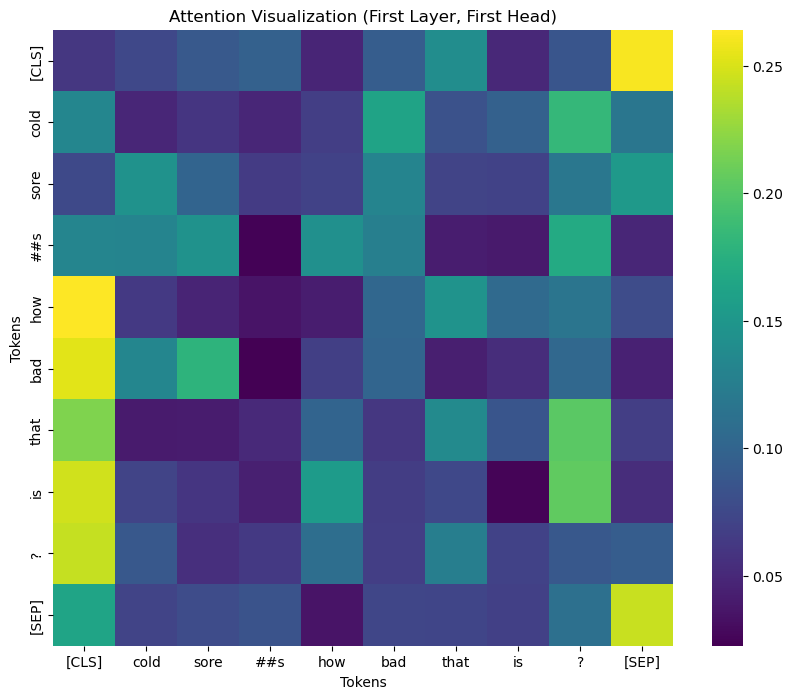

In [260]:
attention = outputs.attentions[0]

tokens_as_list = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

first_head = attention[0, 0].detach().numpy() 

plt.figure(figsize=(10, 8))
sns.heatmap(first_head, xticklabels=tokens_as_list, yticklabels=tokens_as_list, cmap='viridis', annot=False)
plt.title("Attention Visualization (First Layer, First Head)")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.show()

## 8. Data preparation and Tokenization 
Transforming each text into IDs and attention mask. This custom class prepares and tokenize text data before its fed as input in a model. Its also associates each text with the corresponding label. 

In [262]:
class MentalHealthDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [264]:
train_dataset = MentalHealthDataset(train_texts.tolist(), train_labels, tokenizer)
val_dataset = MentalHealthDataset(val_texts.tolist(), val_labels, tokenizer)
test_dataset = MentalHealthDataset(test_texts.tolist(), test_labels, tokenizer)

In [266]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

### 9. Training and Evaluation
The model performs quite well overall. Doing well in classes 2, 4 and 6. Struggles more with class 0 and 1. A training loss of 1.0592 indicates there is room for improvement. A training and validation accuracy of 77% indicates the model is generalizing the data quite well, no issues with overfitting or underfitting. The other metrices aside from accuracy scores vary from class to class, indicating room for improvement.


In [268]:
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)

C:\Users\Fifi\anaconda3\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [270]:
def evaluate(model, data_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels)
    return accuracy_score(true_labels, predictions), classification_report(true_labels, predictions)

In [272]:
epochs = 3
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_acc, val_report = evaluate(model, val_loader)
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(val_report)

Epoch 1/3
Train Loss: 1.0592
Validation Accuracy: 0.7671
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       204
           1       0.61      0.64      0.63       180
           2       0.86      0.79      0.83       213
           3       0.74      0.90      0.81       186
           4       0.93      0.82      0.87       199
           5       0.67      0.78      0.72       193
           6       0.88      0.77      0.82       225

    accuracy                           0.77      1400
   macro avg       0.77      0.77      0.77      1400
weighted avg       0.78      0.77      0.77      1400

Epoch 2/3
Train Loss: 0.5438
Validation Accuracy: 0.7543
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       204
           1       0.51      0.71      0.59       180
           2       0.87      0.78      0.82       213
           3       0.73      0.91      0.81       186
           4      

## 10. Testing
The model can correctly predict 8 out of 10 samples given the test accuracy of 79%. 

In [275]:
test_acc, test_report = evaluate(model, test_loader)
print("\nTest Set Evaluation")
print(f"Test Accuracy: {test_acc:.4f}")
print(test_report)


Test Set Evaluation
Test Accuracy: 0.7900
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       220
           1       0.74      0.52      0.61       201
           2       0.84      0.81      0.83       199
           3       0.78      0.94      0.85       190
           4       0.90      0.88      0.89       183
           5       0.73      0.80      0.76       204
           6       0.91      0.78      0.84       203

    accuracy                           0.79      1400
   macro avg       0.80      0.79      0.79      1400
weighted avg       0.80      0.79      0.79      1400



## 11. Conclusion
The sample data could be increased to improve the model's performance. For this project i selected 1000 rows for each label to cater for the training time on a computer with limited processing power. The model could be implemented in a chat bot application for use in future if trained with more data. The performance could be higher with more epochs and data, if processed in a powerful computer. The model demonstrates reliable performance and performs well generally.